# Visualization of in-situ, ground-based aerosol measurements with satellite data

**Contributors:** Han Huynh (CU Boulder (CIRES); NOAA Chemical Sciences Laboratory (CSL)), Prem Maheshwarkar (University of Paris Est)

*Image courtesy of Chelsea Thompson (NOAA CSL), Charles Brock (NOAA CSL), Adam Ahern (NOAA CSL)*

![Aerosol_instr_graph.png](Aerosol_instr_graph.png)

## Summary

The main motivation of visualizing multi-source aerosol data together is to facilitate the evaluation of satellite aerosol data products (e.g., aerosol optical depth, i.e., AOD) with an aerosol optical model built from in-situ measurements (e.g., microphysical, chemical, and optical measurements). Ground-based measurements, such as AERONET, add another point of AOD comparison.

The notebook contains functions and examples of importing different aerosol data/data formats:
* In-situ aerosol aircraft measurements (e.g., aerosol optical properties, i.e., AOP)
* Ground-based aerosol optical measurement (e.g., AERONET)
* Satellite aerosol data product (aerosol optical thickness, i.e. AOT)

The goal of this notebook is to set up functions to quickly ingest data files (e.g., .ICARTT field data) and visualize them together. The scientific calculations required to 'properly' compare them are not listed here. Note that aerosol extinction extracted from AOP field measurements are not reflected of aerosol extinctions at ambient relative humidity (RH) and temperature. The determination of ambient RH-extinction from aerosol microphysical and chemical measurements are under development and will be included in the future.


## Contents

1. [In-situ aerosol aircraft measurement](#1.-In-situ-aerosol-aircraft-measurement)
2. [Ground-based aerosol measurement (AERONET)](#2.-Ground-based-aerosol-measurement-(AERONET))
3. [Satellite aerosol data product](#3.-Satellite-aerosol-data-product)
4. [Overlay in-situ, ground-based, and satellite aerosol data](#4.-Overlay-in-situ,-ground-based,-and-satellite-aerosol-data)



Contact info: han.huynh@noaa.gov; prem.maheshwarkar@lisa.ipsl.fr

In [4]:
#%pip install regex
# -*- coding: utf-8 -*-

import sys
import os

import pandas as pd
from datetime import datetime, timedelta
from copy import deepcopy
import numpy as np
import regex as re
import matplotlib.dates as mdates

import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter 


  Using cached regex-2024.7.24-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached regex-2024.7.24-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (776 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Basemap to overlay flight track and in situ measurements
#%pip install basemap basemap-data-hires
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs

  Using cached basemap-1.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (9.1 kB)
  Using cached basemap_data_hires-1.3.2-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
Using cached basemap-1.4.1-cp310-cp310-manylinux1_x86_64.whl (935 kB)
Using cached basemap_data_hires-1.3.2-py2.py3-none-any.whl (91.1 MB)
Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib

## 1. In-situ aerosol aircraft measurement

### a) Import in-situ aerosol and flight navigation data

The example files are from a flight over the marine area off the coast of California in June 2023.

In [6]:
# Get path for data folder
data_path = os.path.dirname(os.getcwd())+"/data/in-situ-aerosol"

"""
Grabbing file based on file name matching
"""
def fetch_aer_file(instrument_name, file_ext):
    
    pattern = rf'.*{instrument_name}.*\{file_ext}$'
    for file in os.listdir(data_path):
        if re.match(pattern, file):
            break
    return file


"""
Processing flight navigation file (MetNav) in ICARTT format
"""

def read_nav_icartt(nav_icartt_file):
    
    # Revision number
    rev_no = re.search('_R(.+?).ict', nav_icartt_file).group(1)
    if rev_no == 'A':
        alt_col = 'Pressure_Altitude_ft'
        row_no = 39
    elif rev_no == '0':
        alt_col = 'Pressure_Altitude'
        row_no = 75
    elif rev_no == '1':
        alt_col = 'Pressure_Altitude'
        row_no = 76
    else:
        raise Exception('How do we handle revision numbers different from RA and R0 for MetNav ICARTT file?')
    
    # Mid-pint diameter/Dp for each size bin
    nav_df = pd.read_csv(os.path.join(data_path, nav_icartt_file), skiprows = row_no)
    nav_cols = nav_df.columns.values.tolist()
    # Remove space from column names
    clean_nav_cols = [s.replace(" ","") for s in nav_cols]
    nav_df.columns = clean_nav_cols
    
    # overwrite all -9999 with Nan
    nav_df.mask(nav_df < -9000, inplace=True)
    
    nan_idx = nav_df.index[(nav_df.iloc[:,1:] < -9000).all(axis=1)]
    if len(nan_idx) != 0:
        raise Exception('There are negative values in MetNav ICARTT file!')
    
    # Calculate altitude in km
    nav_df['Pressure_Altitude_km'] = nav_df[alt_col]*0.0003048
    
    # Get date from file name
    date_string = re.search('DC8_(.+?)_R', nav_icartt_file).group(1)
    start_date = datetime.strptime(date_string, '%Y%m%d')
    
    # Convert time to proper datetime
    nav_df['Time_Start_UTC'] = [float(i) for i in nav_df['Time_Start']]
    
    for i in range(len(nav_df)):
        nav_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = nav_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
    
    nav_df['Time_Start_UTC'] = pd.to_datetime(nav_df['Time_Start_UTC'], format='%Y-%m-%d %H:%M:%S')
    
    return nav_df



"""
Processing in-situ aerosol optical properties measurement from a single flight in ICARTT format
At visible wavelength (405 nm, 532 nm, 664 nm), the following data are available:
+ aerosol extinction
+ aerosol absorption
+ RH-aerosol extinctions at two RH setpoints at 664 nm
"""

def read_aop_icartt(aop_icartt_file):
    
    
    # Mid-pint diameter/Dp for each size bin
    aop_df = pd.read_csv(os.path.join(data_path, aop_icartt_file), skiprows = 53)
    aop_cols = aop_df.columns.values.tolist()
    # Remove space from column names
    clean_aop_cols = [s.replace(" ","") for s in aop_cols]
    aop_df.columns = clean_aop_cols 
    
    # overwrite all -9999 with Nan
    # Replace negative value < -9000 with NaN
    aop_df.mask(aop_df < -9000, inplace=True)
    
    nan_idx = aop_df.index[(aop_df.iloc[:, 1:] < -9000).any(axis=1)]
    if len(nan_idx) != 0:
        raise Exception('There are rows with only negative values in AOP ICARTT file!')
    
    # Get date from file name
    date_string = re.search('DC8_(.+?)_R', aop_icartt_file).group(1)
    start_date = datetime.strptime(date_string, '%Y%m%d')
    
    # Convert time to proper datetime
    aop_df['Time_Start_UTC'] = [float(i) for i in aop_df['Time_start']]
    
    for i in range(len(aop_df)):
        aop_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = aop_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
    
    aop_df['Time_Start_UTC'] = pd.to_datetime(aop_df['Time_Start_UTC'], format='%Y-%m-%d %H:%M:%S')


    return aop_df

In [7]:
"""
MetNav data = flight data
"""
nav_icartt_file = fetch_aer_file("MetNav", ".ict")
nav_df = read_nav_icartt(nav_icartt_file)

# Extract flight date from file name
flight_date = re.search('DC8_(.+?)_R', nav_icartt_file).group(1)

"""
Aerosol optical properties in-situ data
"""
aop_icartt_file = fetch_aer_file("AOP", ".ict")
aop_df = read_aop_icartt(aop_icartt_file)

# Get a list of min and max values of latitude and longitude
lat_min = nav_df.Latitude.min() - 1
lat_max = nav_df.Latitude.max() + 1
lon_min = nav_df.Longitude.min() - 1
lon_max = nav_df.Longitude.max() + 1 #data is logged as negative so we need to subtract instead of add to extend the boundary box

# Merge AOP measurements with flight data
nav_aop_df = aop_df.merge(nav_df, how='left', left_on = 'Time_start', right_on='Time_Start', suffixes=('', '_y'))

/tmp/ipykernel_148/3124288765.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2023-06-23 18:15:27' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  nav_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = nav_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
/tmp/ipykernel_148/3124288765.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2023-06-23 18:15:27' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  aop_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = aop_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)


### b) Visualization

In [8]:
"""
Overlay flight track colored by in-situ aerosol optical measurements

"""

def visualize_aer_data_map(nav_aop_df, aer_prop, flight_date):
    params = {'mathtext.default': 'regular' , 'font.size': 18}          
    plt.rcParams.update(params)
    
    # Make the figure
    fig = plt.figure(figsize=(13, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Initialize the basemap
    m = Basemap(llcrnrlat = lat_min-2,
                llcrnrlon = lon_min-2,
                urcrnrlat = lat_max+2,
                urcrnrlon = lon_max+2,
               resolution='h')
    # Get the area of interest imagery
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2500, verbose= True, alpha= .6)
    m.arcgisimage(xpixels = 1500, verbose= True)
    
    # vmax value for the aerosol property
    scat_pts = nav_aop_df[aer_prop]
    vmax_bound = scat_pts.max()  
    
    # Plot aerosol optical property in scatter plot and colored by magnitude of that property
    co_map = ax.scatter(nav_aop_df.Longitude, nav_aop_df.Latitude, s=10, marker='o', 
                            c=nav_aop_df[aer_prop], cmap='plasma', #vmin=100, vmax=300,
                            norm=mp.colors.LogNorm(vmin=1, vmax=vmax_bound),
                            label=flight_date, 
                            alpha=0.8)
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.1)

    cbar = plt.colorbar(co_map, extend='both')
    c_label = aer_prop + ' ($Mm^{-1}$)'
    cbar.set_label(c_label)
    
    # Draw the coasts
    m.drawcoastlines(color='blue', linewidth=3)
    # Draw the states
    m.drawstates(color='firebrick',linewidth=3)


"""
Temporal profile of aerosol optical properties as a function of altitude

"""


'\nTemporal profile of aerosol optical properties as a function of altitude\n\n'

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-128.3056107,28.5494499,-114.9800568,38.027298&bboxSR=4326&imageSR=4326&size=1500,1066&dpi=96&format=png32&transparent=true&f=image


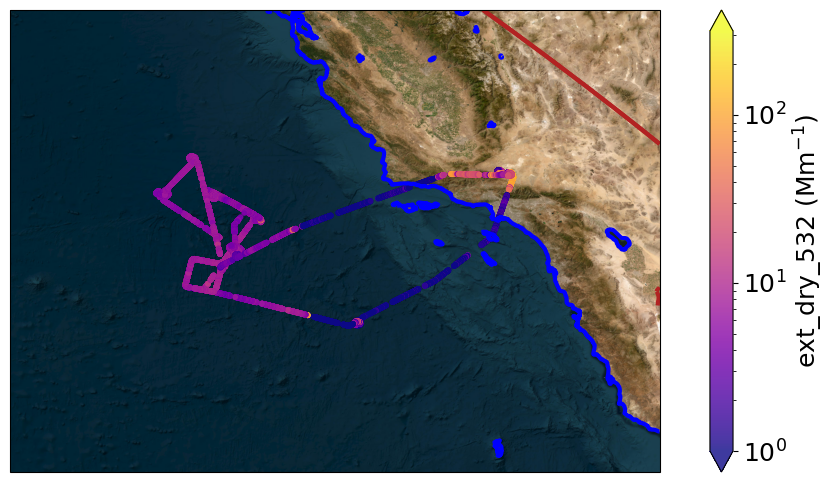

In [9]:
"""
Example: flight path colored by measured dry aerosol extinction at 532 nm

"""
# To know what column name are for the in situ data, do "nav_aop_df.dtypes"
in_situ_aer_prop = 'ext_dry_532'
visualize_aer_data_map(nav_aop_df, in_situ_aer_prop, flight_date)

## 2. Ground-based aerosol measurement (AERONET)

### a) Download AERONET site list for a region

By specifying a region from which we want AERONET measurements (e.g., US), the `download_aoc_list` function will (1) download all AERONET sites into a .csv file with latitude and longitude information and (2) save as a dataframe in the system. We can specify the following to limit the list of AERONET sites:
* Region
* Date range (format: YYYYMMDD)
* Output file name
* Data level

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 27 10:59:45 2022

@author: Maheshwarkar Prem
   
"""
#%pip install wget
from glob import glob
import wget 

   
def download_aoc_list(region, product, start_date, end_date, output_file_name, level):



    # region = 'ILE_DE_FRANCE', 'FRANCE', 'EUROPE', 'INDIA', 'USA', 'GLOBAL'
    avg = '10'
    #level = '10'
    # start_date = 20220704
    # end_date = 20220706
    download = 'on'  # Keep this on to download the data
    ###############################################################################
    if region == 'FRANCE':
        lat_min = 40; lat_max = 60.0; lon_min = -5.0 ; lon_max = 15.0
    elif region == 'ILE_DE_FRANCE':
        lat_min = 47; lat_max = 50.0; lon_min = 1.0 ; lon_max = 5.0
    # elif region == 'EUROPE':
    #     lat_min = 47; lat_max = 50.0; lon_min = 1.0 ; lon_max = 5.0
    elif region == 'INDIA':
        lat_min = 6; lat_max = 38.0; lon_min = 66.0 ; lon_max = 98.0
    elif region == 'USA':
         lat_min = 24; lat_max = 50.0; lon_min = -125 ; lon_max = -67
    elif region == 'GLOBAL':
        lat_min = -90; lat_max = 90.0; lon_min = -180.0 ; lon_max = 180.0

    ###############################################################################


    __db_path__ = data_path
    if glob(__db_path__+'/sites.csv') == [] :
        wget.download('https://aeronet.gsfc.nasa.gov/aeronet_locations_v3.txt', __db_path__ + '/' + 'sites.csv')

    data = pd.read_csv(__db_path__ + '/sites.csv', skiprows=1, delimiter=',')
    data.rename(columns={'Longitude(decimal_degrees)': 'Longitude', 'Latitude(decimal_degrees)':'Latitude'}, inplace=True)

    data_region = data[(data.Latitude > lat_min) & (data.Latitude < lat_max) & (data.Longitude > lon_min) & (data.Longitude < lon_max)]
    data_region = data_region.reset_index()
    start_date = str(start_date); end_date = str(end_date)
    start_year = start_date[0:4]; start_month = start_date[4:6]; start_day = start_date[6:9] 
    end_year = end_date[0:4]; end_month = end_date[4:6]; end_day = end_date[6:9] 

    [total_station, param] = np.shape(data_region)

    year_initial = [start_year] * total_station
    month_initial = [start_month] * total_station
    day_initial = [start_day] * total_station

    year_final = [end_year]* total_station
    month_final = [end_month]* total_station
    day_final = [end_day]* total_station

    level = [level]* total_station
    avg = avg = [avg]* total_station
    product = [product]* total_station
    download = [download]* total_station

    input_df = pd.DataFrame({'year_initial': year_initial, 'month_initial':month_initial, 'day_initial': day_initial,
                               'year_final':year_final, 'month_final': month_final, 'day_final':day_final,'site': data_region.Site_Name,
                               'level':level, 'avg': avg, 'products':product, 'download':download, 'longitude':data_region.Longitude, 'latitude':data_region.Latitude})

    input_df.to_csv(data_path + '/' + output_file_name + '.csv', index=False)
    
    return input_df
    
    #list_aeronet(region, product,start_date, end_date, output_file_name)


if __name__ == '__download_aoc_region___' :
  import sys
  if len(sys.argv) == 1 :

    print("""Usage: 
             Downloads the list of aeronet stations and prepares input file for download_aeronet.py script.
             :\n args: region start_date end_date output_file_name product\n
             Example :\n
             list_aeronet.py FRANCE 20220616 20220618 FRANCE_ACROSS aod/n
             - siz - Size distribution/n
             - rin	- Refractive indicies (real and imaginary)/n
             - cad -	Coincident AOT data with almucantar retrieval/n
             - vol	- Volume concentration, volume mean radius, effective radius and standard deviation/n
             - tab -	AOD absorption/n
             - aod - AOD extinction/n
             - ssa	- Single scattering albedo/n
             - asy -	Asymmetry factor/n
             - frc -	Radiative Forcing/n
             - lid - Lidar and Depolarization Ratios/n
             - flx - Spectral flux/n
             - pfn - Phase function/n
             - pfncoarse - coarse mode phase functions/n
             - pfnfine - fine mode phase functions/n
             - directsun - Aerosol Optical Depth from AERONET direct sun measurements""")
             
  main(*sys.argv[1:])


  Using cached wget-3.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [12]:
"""
Example: download a list of AERONET sites in the US region that has AOD data in the specified date range at the specified data level

"""
region_name = 'USA'
data_product = 'aod'
start_date = '20230601'
end_date = '20230831'
region_aoc_summary_file_name = 'USA_AOD_AERONET_sites'
data_level = '10'

# There will be a generated .csv with the list of AERONET sites but also a dataframe that houses that information
us_aoc_list_df = download_aoc_list(region_name, data_product, start_date, end_date, region_aoc_summary_file_name, data_level)

### b) Download all sites within the specified region

The `download_aoc_sites` function will download each AERONET site in the specified region as an individual .csv file. We need to specify (1) the name of the .csv file generated in the previous step and (2) a name for the output file.

In [11]:
# -*- coding: utf-8 -*-
#%pip install ssl platform
"""
Imported from GitHub 
https://github.com/fabioslopes/download_aeronet_data/blob/master/aeronet_locations_v3.csv

input_file_name: the name of the CSV file that contains all the AERONET sites of the specified region

"""

def download_aoc_sites(input_file_name, inputdatadir):
    name_of_csv_file = input_file_name #'INDIA_COVID'
    # output_file = 'FRANCE_ACROSS' #'INDIA_COVID'
    
    os.chdir(data_path)
    
    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
            ssl._create_default_https_context = ssl._create_unverified_context
    
    '''Creating the folder for raw data download from AERONET web data service'''
    rootdir = data_path
    outputdir = name_of_csv_file
    dircontents = os.sep.join([rootdir, outputdir])
    if not os.path.exists(dircontents):
            os.makedirs(dircontents)
    
    '''Reading the input data to download AERONET data from web data service'''
    inputfilename = name_of_csv_file
    inputdir = os.sep.join([rootdir, inputdatadir])
    filenames = [name for name in os.listdir(inputdir) if name.startswith(inputfilename)]
    nfiles=len(filenames)
    
    print(filenames)
    filenameout = []
    i = 1
    for x in range(0, len(filenames)):
            newfile = os.sep.join([inputdir, filenames[x]])
            if platform.system() == 'Linux':
                filedata = pd.read_csv(newfile)
            else:
                filedata = pd.read_csv(newfile, sep=',' )
                    
            for i in range(0,len(filedata)):
                if filedata['download'][i] == 'on':
                                                
                    if filedata['month_initial'][i] < 10: 
                            filemonthin = '0'+ str(filedata['month_initial'][i])
                    else:
                            filemonthin = str(filedata['month_initial'][i])
                    if filedata['month_final'][i] < 10:
                            filemonthfinal = '0'+ str(filedata['month_final'][i])
                    else:
                            filemonthfinal = str(filedata['month_final'][i])
                    if filedata['day_initial'][i] < 10: 
                            filedayin = '0'+ str(filedata['day_initial'][i])
                    else:
                            filedayin = str(filedata['day_initial'][i])
                    if filedata['day_final'][i] < 10:
                            filedayfinal = '0'+ str(filedata['day_final'][i])
                    else:
                            filedayfinal = str(filedata['day_final'][i])
                    if filedata['level'][i] == 10:
                            filelevel = '10'
                    elif filedata['level'][i] == 15:
                            filelevel = '15'
                    else:
                            filelevel = '20'  
                    # filenameout = str(filedata['year_initial'][i])+filemonthin+filedayin+'_'+\
                    #               str(filedata['year_final'][i])+filemonthfinal+filedayfinal+'_'+\
                    #               filedata['site'][i]+'_level'+filelevel+'.'+filedata['products'][i]
                    
                    filenameout = filedata['site'][i]
                    
                    url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                          '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                          '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                          '&product='+filedata['products'][i].upper()+'&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1'
                    
                    if filedata['products'][i] == 'pfncoarse':
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                                  '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                  '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                  '&product=PFN&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1&pfn_type=1'
    
                    if filedata['products'][i] == 'pfnfine':                                
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                                  '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                  '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                  '&product=PFN&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1&pfn_type=2'
    
                    if filedata['products'][i] == 'directsun':
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site='+filedata['site'][i]+\
                                    '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                    '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                    '&AOD'+filelevel+'=1&AVG='+str(filedata['avg'][i])
                                            
                    filename = wget.download(url, out=os.sep.join([dircontents, filenameout]))
                    print(url)
                    print('downloading....%s of %s files.'%(i, len(filedata)))
                    i = i+1

if __name__ == '__download_aoc_sites__' :
  import sys
  if len(sys.argv) == 1 :

    print("""Usage: 
             Downloads the data from aeronet stations based on list_aeronet.py script.
             :\n args: input_file_name\n
             Example :\n
             download_aeronet.py ACROSS_FRANCE""")
             
  main(*sys.argv[1:])


In [13]:
"""
Example: download all AOD data for the specified time range for each individual AERONET sites 
"""
# Name of the folder to house all individual AERONET sites

aoc_folder_name = 'AERONET_US_sites'
download_aoc_sites(region_aoc_summary_file_name, aoc_folder_name)

## 3. Satellite aerosol data product

### a) PACE testing AOT data

There is no PACE data before February 2024, and we do not access to any aerosol aircraft measurement since PACE's gone live. For the sake of illustration, we use PACE provisionary aerosol optical thickness (AOT) data from 2024 to compare to in situ data.

In [14]:
import earthaccess
import xarray as xr

In [15]:
# Sample aerosol AOT/AOD data (daily at 1 degree)
# Grab the netCDF file of PACE_OCI from the /data folder. The data is provisional and not currently on earthaccess
sample_aod_file = fetch_aer_file("PACE_OCI", ".nc")      
sample_aod_dataset = xr.open_dataset(os.path.join(data_path, sample_aod_file))
pace_aot = sample_aod_dataset["aot_550_db"]

### b) VIIRS AOT data

We grabbed VIIRS-NOAA20 data from earthaccess for the same time period as the PACE-OCI file (2024-07-04).

In [16]:
auth = earthaccess.login(persist=True)

In [17]:
sat_data_date = "2024-07-04"
tspan = (sat_data_date + " 00:00:00", sat_data_date + " 23:59:59")
    
results = earthaccess.search_data(
    short_name="AERDB_D3_VIIRS_NOAA20",
    temporal=tspan
)

paths = earthaccess.open(results)
sample_viirs_df = xr.open_dataset(paths[0])
viirs_aot = sample_viirs_df["Aerosol_Optical_Thickness_550_Land_Ocean_Mean"]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 1.0, 'VIIRS-NOAA20 AOT at 550-nm on 2024-07-04')

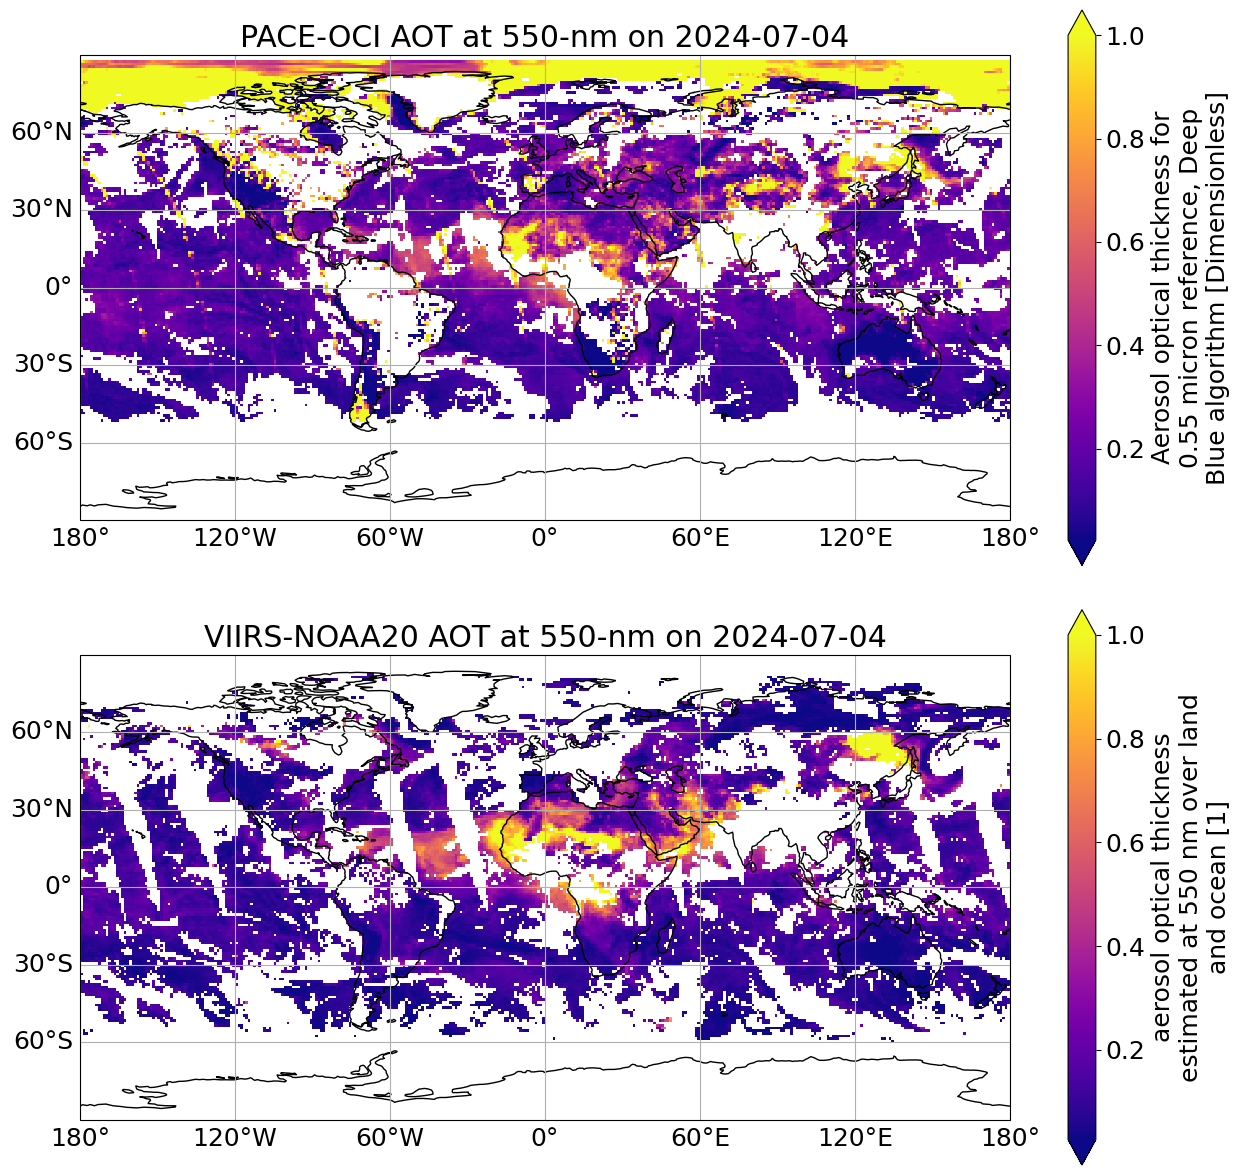

In [18]:
params = {'mathtext.default': 'regular' , 'font.size':18}          
plt.rcParams.update(params)   

figure = plt.figure(figsize=(15,15))
gs = figure.add_gridspec(2, hspace=0.08, wspace=0.05)
axes = gs.subplots(sharex=True, subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.coastlines()
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

cmap_color = "plasma"
vmax_bound = 1

# PACE OCI data
pace_aot.plot(x="lon", y="lat", cmap=cmap_color, vmax=vmax_bound, ax=axes[0], robust=True)
axes[0].set_title('PACE-OCI AOT at 550-nm on ' + sat_data_date)

# VIIRS-NOAA20 data
viirs_aot.plot(x="Longitude_1D", y="Latitude_1D", cmap=cmap_color, vmax=vmax_bound, ax=axes[1], robust=True)
axes[1].set_title('VIIRS-NOAA20 AOT at 550-nm on '+ sat_data_date)

## 4. Overlay in-situ, ground-based, and satellite aerosol data

### a) Overlay .kml flight tracks on top of satellite data

First, we processed .kml or .kmz into a GeoDataFrame. The function `impose_flight_track_pace_data` then plots the flight track over a US map. If latitude and longitude limits (min or max) are specified, the graph will resize accordingly. Note that these limits are optional requirements.

In [19]:
#%pip install geopandas fiona

# Required packages
import cartopy.feature as cfeature
import geopandas as gpd
#from shapely.geometry import Point, Polygon
from fiona.drvsupport import supported_drivers

  Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl.metadata (50 kB)
Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl (15.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
"""
Process kml file
"""
def read_flight_track():

    # Pass in a kml_filename for a marine flight
    pattern = rf'.*\{".kml"}$'
    for file in os.listdir(data_path):
        if re.match(pattern, file):
            sample_kml_file = file

    supported_drivers['LIBKML'] = 'rw'
    df = gpd.read_file(os.path.join(data_path, sample_kml_file))
    
    return df


# Create a figure and an axes with a specific projection
def impose_flight_track_pace_data(plotted_data, flight_track_df, lon_min=None, lon_max=None, lat_min=None, lat_max=None):

    fig = plt.figure(figsize=(15, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    plotted_data.plot(x="lon", y="lat", cmap="plasma", ax=ax, robust=True)
    flight_track_df.loc[[0],'geometry'].plot(color='springgreen', alpha=1, ax=ax)
      
    # Zoom in only if lat/lon min/max values are passed
    if not lat_min:
        # Set extent to focus on the US
        ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]

    else:
        # Zoom in   
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_aspect('equal')
   
    # Add features to the map
    ax.add_feature(cfeature.STATES, edgecolor='blue')  # Add state boundaries with black edges
    ax.add_feature(cfeature.BORDERS, linestyle='--')  # Add country borders with dashed lines
    ax.add_feature(cfeature.COASTLINE, edgecolor='firebrick')  # Add coastline
    
    # Add gridlines (optional)
    ax.gridlines(draw_labels=True, linewidth=0.2)
    
    
    plt.show()


# Create a figure and an axes with a specific projection
def compare_flight_track_sat_data(pace_aot, viirs_aot, flight_track_df, lon_min=None, lon_max=None, lat_min=None, lat_max=None, ):

    params = {'mathtext.default': 'regular' , 'font.size':18}          
    plt.rcParams.update(params)   
    
    figure = plt.figure(figsize=(15,15))
    gs = figure.add_gridspec(2, hspace=0.08, wspace=0.05)
    axes = gs.subplots(sharex=True, subplot_kw={'projection': ccrs.PlateCarree()})
  
    for ax in axes:
        ax.coastlines()
        ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.2)
        
        # Add features to the map
        ax.add_feature(cfeature.STATES, edgecolor='blue')  # Add state boundaries with black edges
        ax.add_feature(cfeature.BORDERS, linestyle='--')  # Add country borders with dashed lines
        ax.add_feature(cfeature.COASTLINE, edgecolor='firebrick')  # Add coastline

        # Zoom in only if lat/lon min/max values are passed
        if not lat_min:
            # Set extent to focus on the US
            ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]
    
        else:
            # Zoom in   
            ax.set_xlim(lon_min, lon_max)
            ax.set_ylim(lat_min, lat_max)
            ax.set_aspect('equal')
        
    # Heatmap
    cmap_color = "plasma"
    vmax_bound = 1
    # PACE OCI data
    pace_aot.plot(x="lon", y="lat", cmap=cmap_color, vmax=vmax_bound, ax=axes[0], robust=True)
    # Flight track    
    #flight_track_df.plot(color='springgreen', alpha=1, ax=axes[0])
    axes[0].set_title('PACE-OCI AOT at 550-nm on ' + sat_data_date)
    
    # VIIRS-NOAA20 data
    viirs_aot.plot(x="Longitude_1D", y="Latitude_1D", cmap=cmap_color, vmax=vmax_bound, ax=axes[1], robust=True)
    # Flight track    
    #flight_track_df.plot(color='springgreen', alpha=1, ax=axes[1])
    axes[1].set_title('VIIRS-NOAA20 AOT at 550-nm on '+ sat_data_date)


    plt.show()


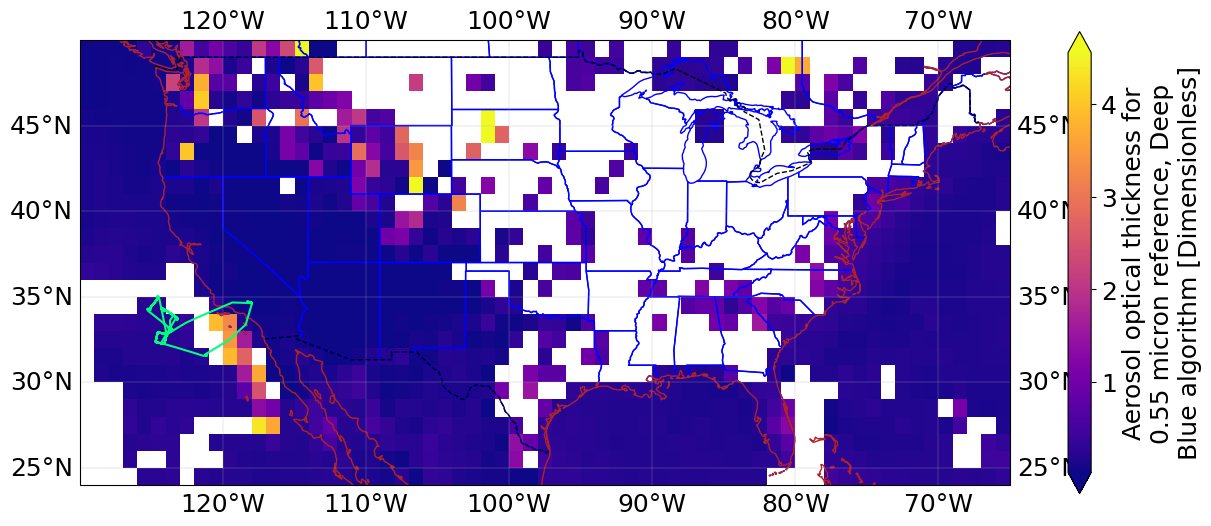

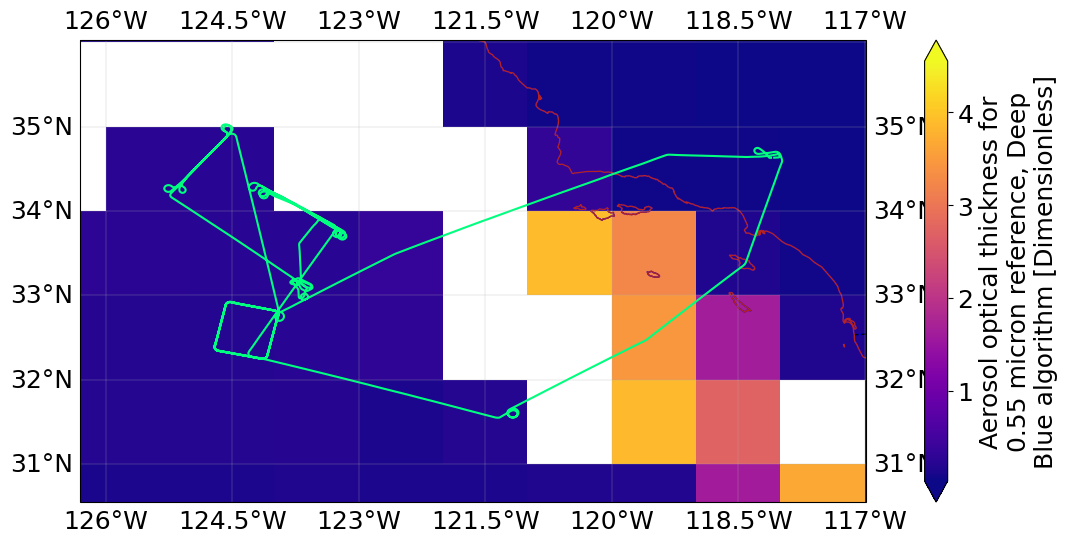

In [23]:
"""
An example of a Pacific marine flight track overlaid on a heatmap of PACE-OCI AOT at 550 nm: 
(top) US-top-view
(bottom) zoomed in marine area

"""

# Read .kml file
flight_track_df = read_flight_track()

# full US view
impose_flight_track_pace_data(pace_aot, flight_track_df)

# zoomed-in
impose_flight_track_pace_data(pace_aot, flight_track_df, lon_min, lon_max, lat_min, lat_max)

### b) Overlay aerosol props on a flight track on a satellite data map

In [25]:
# Create a figure and an axes with a specific projection
def overlay_aer_prop_sat_data(pace_aot, viirs_aot, nav_aop_df, aer_prop, lon_min=None, lon_max=None, lat_min=None, lat_max=None):

    params = {'mathtext.default': 'regular' , 'font.size':15}          
    plt.rcParams.update(params)   
    
    figure = plt.figure(figsize=(12,14))
    gs = figure.add_gridspec(2, hspace=0.1, wspace=0.05)
    axes = gs.subplots(sharex=True, subplot_kw={'projection': ccrs.PlateCarree()})


    # Heatmap
    cmap_color = "plasma"
    vmax_bound = 1
    # PACE OCI data
    pace_aot.plot(x="lon", y="lat", cmap=cmap_color, vmax=vmax_bound, ax=axes[0], robust=True)
    axes[0].set_title('PACE-OCI AOT at 550-nm on ' + sat_data_date)
    
    # VIIRS-NOAA20 data
    viirs_aot.plot(x="Longitude_1D", y="Latitude_1D", cmap=cmap_color, vmax=vmax_bound, ax=axes[1], robust=True)
    axes[1].set_title('VIIRS-NOAA20 AOT at 550-nm on '+ sat_data_date)


        # vmax value for the aerosol property
    scat_pts = nav_aop_df[aer_prop]
    vmax_aer_bound = scat_pts.max()

    
    for ax in axes:
        ax.coastlines()
        ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.2)
        
        # Add features to the map
        ax.add_feature(cfeature.STATES, edgecolor='blue')  # Add state boundaries with black edges
        ax.add_feature(cfeature.BORDERS, linestyle='--')  # Add country borders with dashed lines
        ax.add_feature(cfeature.COASTLINE, edgecolor='blue', linewidth=2)  # Add coastline

        # Zoom in only if lat/lon min/max values are passed
        if not lat_min:
            # Set extent to focus on the US
            ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]
    
        else:
            # Zoom in   
            ax.set_xlim(lon_min, lon_max)
            ax.set_ylim(lat_min, lat_max)
            ax.set_aspect('equal')

    
        # Plot aerosol optical property in scatter plot and colored by magnitude of that property
        co_map = ax.scatter(nav_aop_df.Longitude, nav_aop_df.Latitude, s=100, marker='o', 
                        #edgecolor='springgreen', linewidths=0.05,
                        c=scat_pts, cmap='inferno', #vmin=100, vmax=300,
                        norm=mp.colors.LogNorm(vmin=1, vmax=vmax_aer_bound),
                        alpha=0.8)
    
    # add color bar below chart
    cbar = plt.colorbar(co_map, ax=axes[1], orientation = 'horizontal', extend='both', fraction=0.05)
    c_label = aer_prop + ' ($Mm^{-1}$)'
    cbar.set_label(c_label)

    
    
    plt.show()

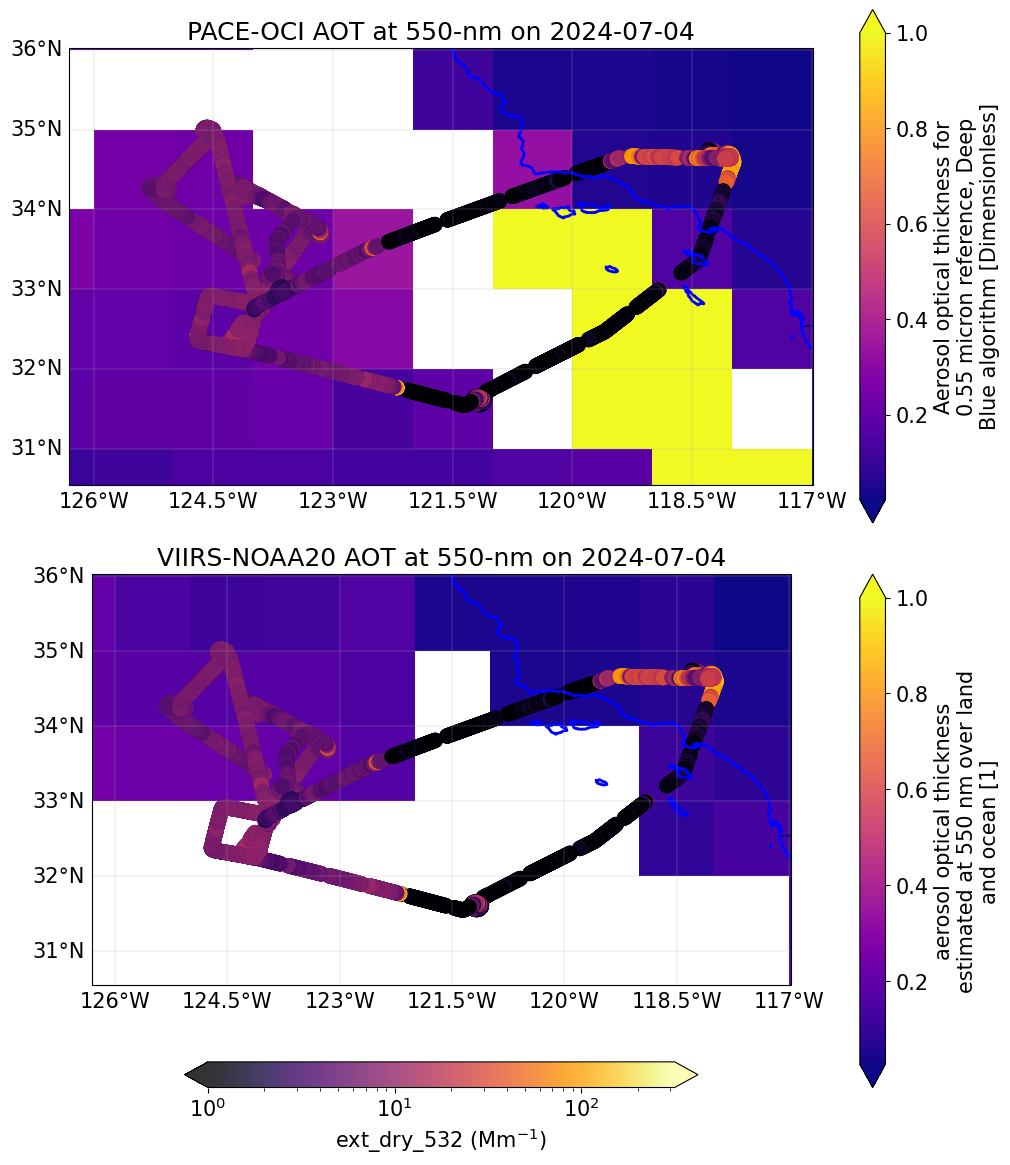

In [26]:
overlay_aer_prop_sat_data(pace_aot, viirs_aot, nav_aop_df, in_situ_aer_prop, lon_min, lon_max, lat_min, lat_max)

### c) Overlay AERONET sites closest to the flight track on the map

Get a list of AERONET site names that are within the pre-set boundary for the flight track.

In [27]:
"""
Get a list of AERONET locations closest to flight tracks
"""
def get_nearest_aoc_sites(lon_min, lon_max, lat_min, lat_max):
    aoc_site_list = []
    for i in range(len(us_aoc_list_df)):
        site = us_aoc_list_df.loc[i, 'site']
        longitude = us_aoc_list_df.loc[i, 'longitude']
        latitude = us_aoc_list_df.loc[i, 'latitude']
        
        if (lon_min <= longitude <= lon_max) & (lat_min <= latitude <= lat_max):
            aoc_site_list.append(site)
    
    # Get the corresponding subset of US AERONET sites
    filtered_us_aoc_list_df = us_aoc_list_df[us_aoc_list_df['site'].isin(aoc_site_list)].reset_index(drop=True)
    
    return filtered_us_aoc_list_df



"""
Overlay flight track over PACE data
"""
def overlay_aoc_flight_track(flight_track_df, filtered_us_aoc_list_df):

    params = {'mathtext.default': 'regular' , 'font.size': 18}          
    plt.rcParams.update(params)
    
    # Make the figure
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Initialize the basemap
    m = Basemap(llcrnrlat = lat_min-2,
                llcrnrlon = lon_min-2,
                urcrnrlat = lat_max+2,
                urcrnrlon = lon_max+2,
               resolution='h')

    # Get the area of interest imagery
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2500, verbose= True, alpha= .6)
    m.arcgisimage(xpixels = 1500, verbose= True)
    
    # Plot flight track
    flight_track_df.plot(column=None, color='springgreen', linewidth=3, alpha=1, categorical=False, legend=False, ax=ax)
    
    # Indicate AERONET site with names
    #for site in aoc_site_list:
        #row = us_aoc_list_df[us_aoc_list_df.site == site]
    m.scatter(filtered_us_aoc_list_df['longitude'], filtered_us_aoc_list_df['latitude'], marker='*', s=250, color='magenta')
    
    
    # Annotate each point
    aoc_site_list = filtered_us_aoc_list_df['site'].values 
    for i, label in enumerate(aoc_site_list):
        ax.annotate(label, (filtered_us_aoc_list_df['longitude'][i], filtered_us_aoc_list_df['latitude'][i]), 
                    textcoords="offset points", xytext=(0,5), ha='center',
                    fontsize=10, color='firebrick', fontweight='bold')
    
    
    # Draw the coasts
    m.drawcoastlines(color='blue', linewidth=3)
    # Draw the states
    m.drawstates(color='firebrick',linewidth=3)

    fig.suptitle('Flight '+flight_date, y=0.85)



"""
Overlay AERONET sites over flight track colored with aerosol properties
"""
def overlay_aoc_aer_data(nav_aop_df, aer_prop, filtered_us_aoc_list_df):

    params = {'mathtext.default': 'regular' , 'font.size': 15}          
    plt.rcParams.update(params)

    # Make the figure
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Initialize the basemap
    m = Basemap(llcrnrlat = lat_min-2,
                llcrnrlon = lon_min-2,
                urcrnrlat = lat_max+2,
                urcrnrlon = lon_max+2,
               resolution='h')

    # vmax value for the aerosol property
    scat_pts = nav_aop_df[aer_prop]
    vmax_bound = scat_pts.max()
    
    # Get the area of interest imagery
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2500, verbose= True, alpha= .6)
    m.arcgisimage(xpixels = 1500, verbose= True)
    
    # Plot aerosol optical property in scatter plot and colored by magnitude of that property
    co_map = ax.scatter(nav_aop_df.Longitude, nav_aop_df.Latitude, s=10, marker='o', 
                            c=scat_pts, cmap='inferno', #vmin=100, vmax=300,
                            norm=mp.colors.LogNorm(vmin=1, vmax=vmax_bound),
                            alpha=0.8)
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.1)

    cbar = plt.colorbar(co_map, extend='both', fraction=0.05)
    c_label = aer_prop + ' ($Mm^{-1}$)'
    cbar.set_label(c_label)
    # Indicate AERONET site with names
    #for site in aoc_site_list:
        #row = us_aoc_list_df[us_aoc_list_df.site == site]
    m.scatter(filtered_us_aoc_list_df['longitude'], filtered_us_aoc_list_df['latitude'], marker='*', s=100, color='magenta')
    
    
    # Annotate each point
    aoc_site_list = filtered_us_aoc_list_df['site'].values 
    for i, label in enumerate(aoc_site_list):
        # Annotate every other AERONET sites for clarity
        if i % 2 == 0:
            ax.annotate(label, (filtered_us_aoc_list_df['longitude'][i], filtered_us_aoc_list_df['latitude'][i]), 
                    textcoords="offset points", xytext=(0,5), ha='center',
                    fontsize=10, color='firebrick', fontweight='bold')
    
    
    # Draw the coasts
    m.drawcoastlines(color='blue', linewidth=3)
    # Draw the states
    m.drawstates(color='firebrick',linewidth=3)

    ax.set_title('Flight '+flight_date, y=1)

In [28]:
# Get the path for the directory and get all the AERONET site names from the directory
aoc_dir = os.path.join(data_path, aoc_folder_name)
all_aoc_file_names = os.listdir(aoc_dir)

# Get all nearest AOC sites
filtered_aoc_sites_df = get_nearest_aoc_sites(lon_min, lon_max, lat_min, lat_max)

# A list of AERONET site data files
filtered_list = [s for s in all_aoc_file_names if any(sub in s for sub in filtered_aoc_sites_df.site.tolist())]

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-128.3056107,28.5494499,-114.9800568,38.027298&bboxSR=4326&imageSR=4326&size=1500,1066&dpi=96&format=png32&transparent=true&f=image


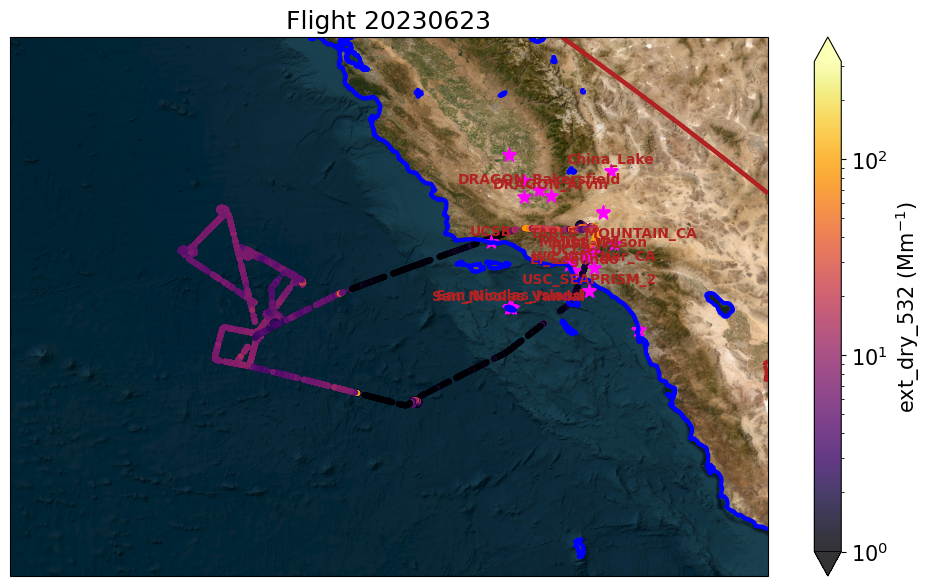

In [29]:
# Overlay flight track on basemap
#overlay_aoc_flight_track(flight_track_df, filtered_aoc_sites_df)
# Overlay aerosol data on basemap
overlay_aoc_aer_data(nav_aop_df, in_situ_aer_prop, filtered_aoc_sites_df)

In [30]:
# Create a figure and an axes with a specific projection
def overlay_aoc_sat_data(pace_aot, nav_aop_df, aer_prop, filtered_us_aoc_list_df, lon_min=None, lon_max=None, lat_min=None, lat_max=None):

    params = {'mathtext.default': 'regular' , 'font.size':18}          
    plt.rcParams.update(params)   
    
    fig = plt.figure(figsize=(20, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())


    # Heatmap
    cmap_color = "plasma"
    vmax_bound = 1
    # PACE OCI data
    pace_aot.plot(x="lon", y="lat", cmap=cmap_color, vmax=vmax_bound, ax=ax, robust=True)
    ax.set_title('PACE-OCI AOT at 550-nm on ' + sat_data_date)

    ax.coastlines()
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.2)
    
    # Add features to the map
    ax.add_feature(cfeature.STATES, edgecolor='blue')  # Add state boundaries with black edges
    ax.add_feature(cfeature.BORDERS, linestyle='--')  # Add country borders with dashed lines
    ax.add_feature(cfeature.COASTLINE, edgecolor='blue', linewidth=2)  # Add coastline

    # Zoom in only if lat/lon min/max values are passed
    if not lat_min:
        # Set extent to focus on the US
        ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]

    else:
        # Zoom in   
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_aspect('equal')


    # Indicate AERONET site with names
    ax.scatter(filtered_us_aoc_list_df['longitude'], filtered_us_aoc_list_df['latitude'], marker='*', s=150, color='limegreen')
    
    # Annotate each point
    aoc_site_list = filtered_us_aoc_list_df['site'].values 
    for i, label in enumerate(aoc_site_list):
        if i % 2 == 0:
            ax.annotate(label, (filtered_us_aoc_list_df['longitude'][i], filtered_us_aoc_list_df['latitude'][i]), 
                    textcoords="offset points", xytext=(5,10), ha='center',
                    fontsize=10, color='magenta', fontweight='bold')
      

    # vmax value for the aerosol property
    scat_pts = nav_aop_df[aer_prop]
    vmax_aer_bound = scat_pts.max()
  
    # Plot aerosol optical property in scatter plot and colored by magnitude of that property
    co_map = ax.scatter(nav_aop_df.Longitude, nav_aop_df.Latitude, s=200, marker='o', 
                    #edgecolor='springgreen', linewidths=0.05,
                    c=scat_pts, cmap='viridis', #vmin=100, vmax=300,
                    norm=mp.colors.LogNorm(vmin=1, vmax=vmax_aer_bound),
                    alpha=0.8)

         
    # add color bar below chart
    cbar = plt.colorbar(co_map, ax=ax, orientation='horizontal', extend='both', fraction=0.07)
    c_label = aer_prop + ' ($Mm^{-1}$)'
    cbar.set_label(c_label)


    plt.show()

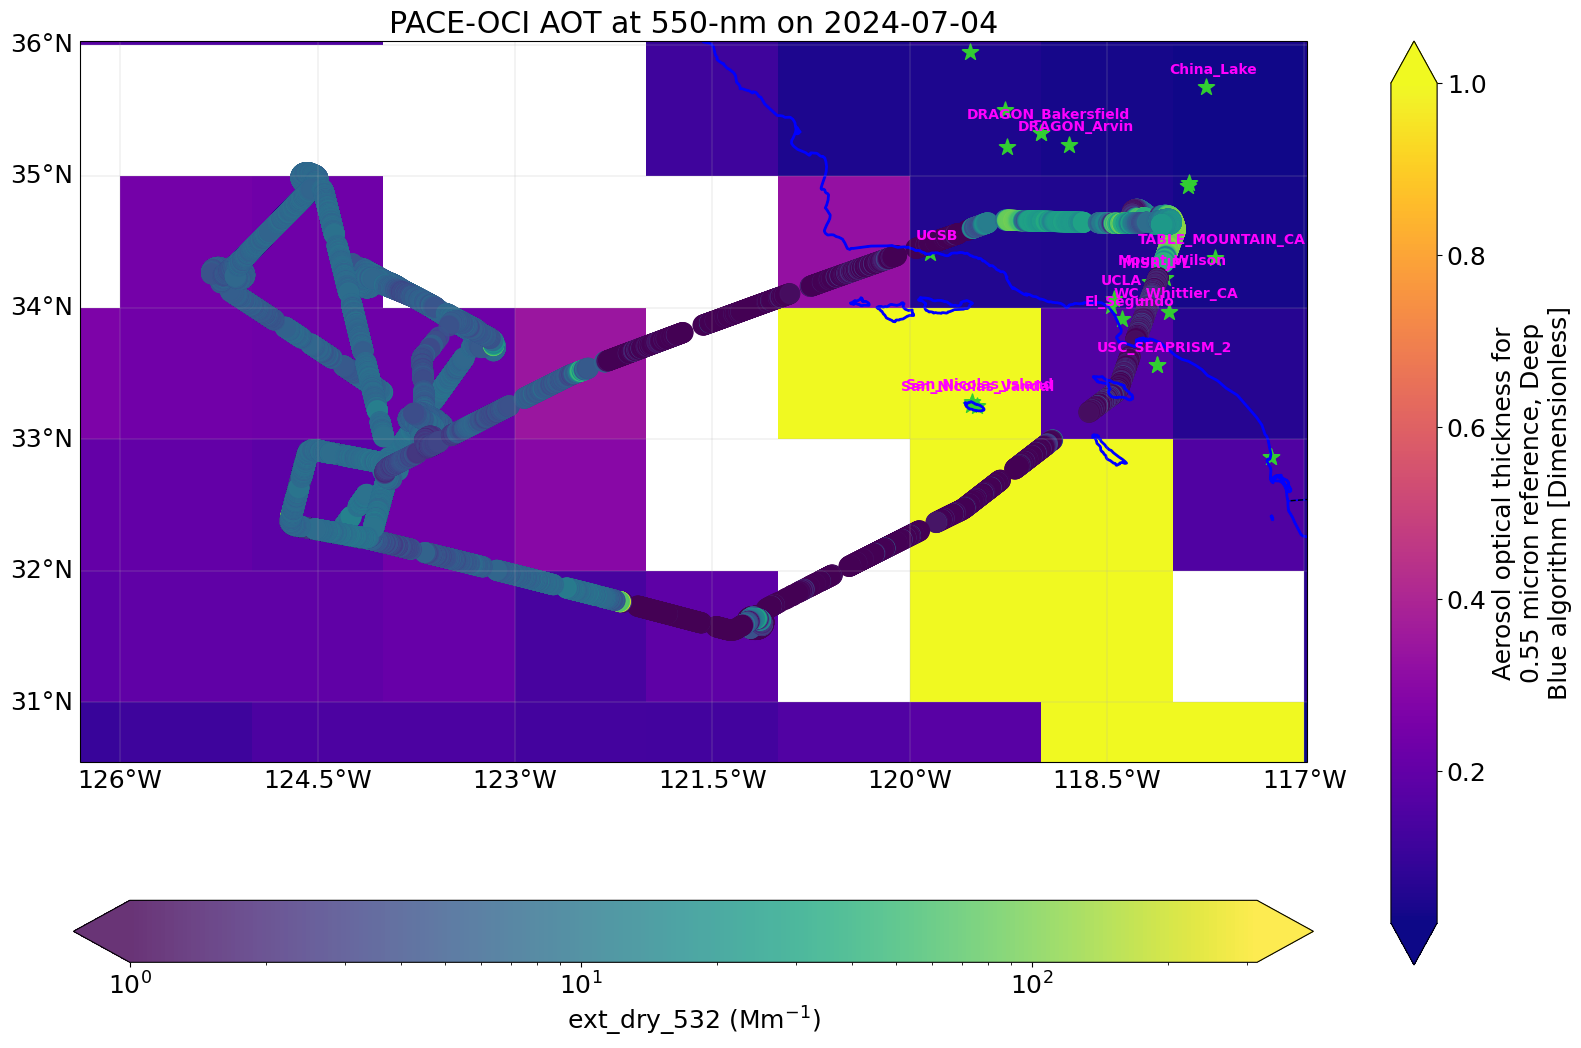

In [31]:
overlay_aoc_sat_data (pace_aot, nav_aop_df, in_situ_aer_prop, filtered_aoc_sites_df, lon_min, lon_max, lat_min, lat_max)